In [ ]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from google.colab.patches import cv2_imshow

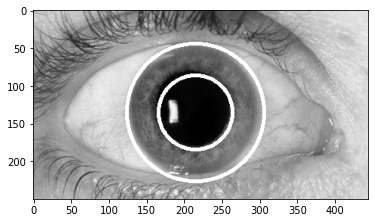

In [ ]:
#SEGMENTATION

#convert image to a gray image
boundary=[] #initialize empty list that will eventually contain all the images with boundaries
centers=[] #initialize empty list that will contain the centers of the boundary circles
img = cv2.imread('/content/Diabetic image.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
draw_img=img

# remove noise by blurring the image
blur = cv2.bilateralFilter(img, 9,75,75)
img=blur

#noise removal, erosion is followed by dilation    
#erosion - It removes the small anomalies ;
#dilation - It fills the holes and broken areas ; It increases the brightness of the objects    
img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
img = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))


#estimate the center of pupil
horizontalProjection = np.mean(img,0);
verticalProjection = np.mean(img,1);
center_x=horizontalProjection.argmin()
center_y=verticalProjection.argmin()

#recalculate of pupil centres by concentrating on a 120X120 area
centrecrop_x = img[center_x-60:center_x+60]
centrecrop_y = img[center_y-60:center_y+60]
horizontalProjection = np.mean(centrecrop_y,0);
verticalProjection = np.mean(centrecrop_x,0);
crop_center_x=horizontalProjection.argmin()
crop_center_y=verticalProjection.argmin()

cimg=img.copy()
cv2.circle(cimg,(crop_center_x,crop_center_y),1,(255,0,0),2)

#apply Canny edge detector on the masked image
maskimage = cv2.inRange(img, 0, 70)
output = cv2.bitwise_and(img, maskimage)
edged = cv2.Canny(output, 100, 220)

#Apply Hough transform to find potential boundaries of pupil
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)

#define the center of the pupil
a = (crop_center_x,crop_center_y)

out = img.copy()
min_dst=math.inf
for i in circles[0]:
    #find the circle whose center is closest to the approx center found above
    b=(i[0],i[1])
    dst = distance.euclidean(a, b)
    if dst<min_dst:
        min_dst=dst
        k=i
        
#draw the inner boundary
cv2.circle(draw_img, (k[0], k[1]), k[2], (255, 0, 0), 3)

pupil=circles[0][0]
radius_pupil = int(k[2])

#draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary 
cv2.circle(draw_img, (k[0], k[1]), radius_pupil+42, (255, 0, 0), 3)

plt.imshow(draw_img, cmap='gray')
centers.append([k[0],k[1],k[2]])


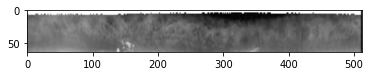

In [ ]:
#NORMALIZATION

cent=0

#load pupil centers and radius of inner circles
center_x = centers[cent][0]
center_y = centers[cent][1]
radius_pupil=int(centers[cent][2])

iris_radius = 35 # width of space between inner and outer boundary

#define equally spaced interval to iterate over
nsamples = 360
samples = np.linspace(0,2*np.pi, nsamples)[:-1]
polar = np.zeros((iris_radius, nsamples))
for r in range(iris_radius):
    for theta in samples:
        #get x and y for values on inner boundary
        x = (r+radius_pupil)*np.cos(theta)+center_x
        y = (r+radius_pupil)*np.sin(theta)+center_y
        x=int(x)
        y=int(y)
        
        try:
        #convert coordinates
            polar[r][int((theta*nsamples)/(2*np.pi))] = draw_img[y][x]
        except IndexError: #ignores values which lie out of bounds
            pass
        continue
res = cv2.resize(polar,(512,64))
plt.imshow(res, cmap='gray')

cent+=1


In [ ]:
#res = res.astype(np.uint8)
#im=cv2.equalizeHist(res)
#plt.imshow(im,cmap='gray')

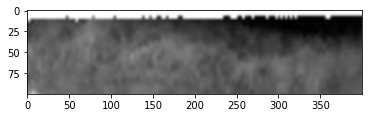

In [ ]:
#EXTRACTING THE REGION OF INTEREST

roi = res[0:50, 150:350]
roi = cv2.pyrUp(roi)
plt.imshow(roi,cmap='gray')

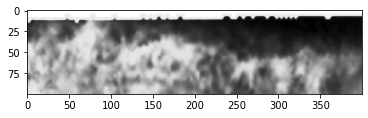

In [ ]:
roi = roi.astype(np.uint8)
im=cv2.equalizeHist(roi)
plt.imshow(im,cmap='gray')

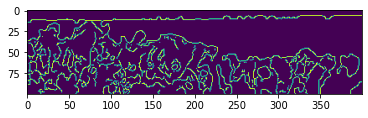

In [ ]:
#APPLYING CANNY EDGE DETECTOR FOR EASY DISTINGUISHABILITY

maskimage_ = cv2.inRange(im, 100, 350)
output_ = cv2.bitwise_and(im, maskimage_)
edged_ = cv2.Canny(output_, 50, 130)
plt.imshow(edged_)

In [ ]:
gray_level = 16
def maxGrayLevel(im):
    max_gray_level = 0
    (height, width) = im.shape
    print(height, width)
    for y in range(height):
        for x in range(width):
            if im[y][x] > max_gray_level:
                max_gray_level = im[y][x]
    return max_gray_level + 1


def getGlcm(input, d_x, d_y):
    srcdata = input.copy()
    ret = [[0.0 for i in range(gray_level)] for j in range(gray_level)]
    (height, width) = input.shape

    max_gray_level = maxGrayLevel(input)

    
    if max_gray_level > gray_level:
        for j in range(height):
            for i in range(width):
                srcdata[j][i] = srcdata[j][i] * gray_level / max_gray_level

    for j in range(height - d_y):
        for i in range(width - d_x):
            rows = srcdata[j][i]
            cols = srcdata[j + d_y][i + d_x]
            ret[rows][cols] += 1.0

    for i in range(gray_level):
        for j in range(gray_level):
            ret[i][j] /= float(height * width)

    return ret


def feature_computer(p):
    Con = 0.0
    Eng = 0.0
    Asm = 0.0
    Idm = 0.0
    for i in range(gray_level):
        for j in range(gray_level):
            Con += (i - j) * (i - j) * p[i][j]
            Asm += p[i][j] * p[i][j]
            Idm += p[i][j] / (1 + (i - j) * (i - j))
            if p[i][j] > 0.0:
                Eng += p[i][j] * math.log(p[i][j])
    return Asm, Con, -Eng, Idm
    


In [ ]:
glcm_0=getGlcm(im, 1,0)
asm,con,eng,idm=feature_computer(glcm_0)
print(asm,con,eng,idm)

100 400
0.03855884624999999 0.4607 3.5065847898607068 0.8626843096379345
